Authors: Naomi Naik and Aparna Radhakrishnan

In [ ]:
##  Compare the two CMIP6 AWS/s3 buckets
- the s3://cmip6-pds/ datasets are in zarr format
- the s3://esgf-world/ datasets are collections of netcdf files

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
import sys

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [18,4]

import matplotlib.style
import matplotlib as mpl
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'

In [7]:
zarr_cat = 'https://cmip6-pds.s3.amazonaws.com/compare/pangeo-cmip6-noQC.csv.gz' #created by Naomi on March 22nd
netcdf_cat = 'https://cmip6-nc.s3.us-east-2.amazonaws.com/esgf-world.csv.gz'

#TODO - open [pattern]*.parquet or get pointers from manifest
nc_inventory_file1 = "s3://s3-inventory-dest/esgf-world/cmip6-inventory/data/0629d45e-8784-43fd-8caa-6218a30b0d65.parquet"
nc_inventory_file2 = "s3://s3-inventory-dest/esgf-world/cmip6-inventory/data/56c3027c-397d-42d8-a95b-877e2270df2e.parquet"



In [11]:
def bytesto(bytes, to, bsize=10):
    a = {'k' : 3, 'm': 6, 'g' : 9, 't' : 12}
    return(bytes / pow(bsize, a[to]))
#Usage: bytesto(size_in_bytes,'g')


In [12]:
#make sure your credentials file is available, otherwise the following read will not work
nc_inventory_pd1 = pd.read_parquet(nc_inventory_file1,engine="pyarrow")
nc_inventory_pd2 = pd.read_parquet(nc_inventory_file2,engine="pyarrow")


nc_inventory_pd = pd.concat([nc_inventory_pd1, nc_inventory_pd2])


size_b = (nc_inventory_pd['size'].sum())
total_from_parquet = bytesto(size_b,'t') #TODO why the rest of the objects are not reflected in the parquet
print(total_from_parquet)

663.957892732915


In [13]:
nc_inventory_pd 

,bucket,key,size,last_modified_date
0,esgf-world,CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/histo...,530948425,2021-02-19 01:08:28+00:00
1,esgf-world,CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/histo...,532579334,2021-02-19 01:08:28+00:00
2,esgf-world,CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/histo...,531180040,2021-02-19 01:08:28+00:00
3,esgf-world,CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/histo...,530247237,2021-02-19 01:08:29+00:00
4,esgf-world,CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/histo...,530980286,2021-02-19 01:08:40+00:00
...,...,...,...,...
221363,esgf-world,CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/histo...,529994989,2021-02-19 01:08:17+00:00
221364,esgf-world,CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/histo...,530964243,2021-02-19 01:08:17+00:00
221365,esgf-world,CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/histo...,532124629,2021-02-19 01:08:17+00:00
221366,esgf-world,CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/histo...,530500461,2021-02-19 01:08:18+00:00


In [14]:
#TODO, Zarr side of things, after a parquet file is available.

#  read csv file, make the dataset identifiers comparable
dzarr = pd.read_csv(zarr_cat, dtype='unicode')
# vstore is same as zstore, but with the version at the end
dzarr['zstore'] = dzarr.apply(lambda row: row.zstore.split('s3://cmip6-pds/')[-1].split('v20')[0], axis = 1)
dzarr['vstore'] = dzarr.apply(lambda row: row.zstore + 'v' + str(row.version)+'/', axis = 1)
dzarr = dzarr.sort_values(by=['version']).drop_duplicates(subset =["zstore"],keep='last')

dzarr['size'] = 0 #TOBEADDED after parquet file is available for cmip6-pds

In [15]:
#esgf-world catalog

dnc = pd.read_csv(netcdf_cat, dtype='unicode')
dnc['key'] = dnc.apply(lambda row: row.path.split('s3://esgf-world/')[-1], axis = 1) #Add key or reuse path as needed--since parquet has the key, for merging later on


In [16]:
print(len(dnc)) 
print(len(nc_inventory_pd)) 

949450
949732


In [17]:
#merge dnc and nc_inventory_pd to incorporate size and then remove version duplicates

dnctmp = dnc.merge(nc_inventory_pd, on='key', how='outer', suffixes=['', '_'], indicator=True)
dnetcdf = dnctmp[dnctmp._merge=='both']
dnetcdf = dnetcdf[dnetcdf['size'].notna()] 
dnetcdf = dnetcdf.drop(['frequency', 'modeling_realm'], axis=1) #since its NA in esgf-world csv
dnetcdf['zstore'] = dnetcdf.apply(lambda row: row.key.split('s3://esgf-world/')[-1].split('v20')[0], axis = 1)
dnetcdf['vstore'] = dnetcdf.apply(lambda row: row.zstore + str(row.version)+'/', axis = 1)

#298 in inv, not in intake
#221384 in intake only


TO BE EXPLAINED -- S3 inventory parquet versus intake_esm catalog discrepancies 

In [18]:
print(len(dnctmp[dnctmp._merge=='right_only']))
#about 298 not in intake catalog- this could be because of elimination of problem files.
#TODO see one example, why did it not make it to intake

303


In [20]:
print(len(dnctmp[dnctmp._merge=='left_only']))
#221384 not in parquet s3 inventory, whereas its in intake. Does seem to be in s3 esgf-world too. TODO-See why
dnctmp[dnctmp._merge=='left_only']['key'] #example

21


153846    CMIP6/CMIP/E3SM-Project/E3SM-1-0/piControl/r1i...
153848    CMIP6/CMIP/E3SM-Project/E3SM-1-0/piControl/r1i...
153850    CMIP6/CMIP/E3SM-Project/E3SM-1-0/piControl/r1i...
153855    CMIP6/CMIP/E3SM-Project/E3SM-1-0/piControl/r1i...
276387    CMIP6/CMIP/IPSL/IPSL-CM6A-LR/abrupt-4xCO2/r1i1...
276388    CMIP6/CMIP/IPSL/IPSL-CM6A-LR/abrupt-4xCO2/r1i1...
397052    CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/AE...
397092    CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/AE...
397112    CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/AE...
397149    CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/AE...
397203    CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/AE...
397274    CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/AE...
397367    CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/AE...
397387    CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/AE...
397503    CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Am...
397523    CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Am...
397699    CMIP6/CMIP/NCAR/CESM2/abrupt-4

In [23]:
#optional QA
searchval = 'CMIP6/AerChemMIP/AS-RCEC/TaiESM1/histSST-piNTCF/r1i1p1f1/AERmon/ps/gn/v20200318/ps_AERmon_TaiESM1_histSST-piNTCF_r1i1p1f1_gn_185001-201412.nc'
nc_inventory_pd.loc[nc_inventory_pd['key'] == searchval]

,bucket,key,size,last_modified_date
1,esgf-world,CMIP6/AerChemMIP/AS-RCEC/TaiESM1/histSST-piNTC...,243189002,2020-11-04 21:06:45+00:00


In [49]:
#QA-crosscheck if needed

#searchval = 'CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Amon/rlus/gr1/'
#d= dnetcdf.loc[dnetcdf['zstore']== searchval] 
#dd= d.loc[d['version']== 'v20180701']
#print(dd['size'].sum())#264,327,907


In [24]:
#get aggregate size for each dataset , group by unique facets OR JUST zstore, but we need the other columns.
#TODO add model

dnetcdf=dnetcdf.groupby(['zstore','model','version','mip_table','institute','variable','ensemble_member','grid_label','experiment_id'], as_index=False).sum('size') #sum()['size'].sum()
dnetcdf = dnetcdf.sort_values(by=['version'])
dnetcdf = dnetcdf.drop_duplicates(subset=["zstore"],keep='last')


#.reset_index()



In [25]:
dnetcdf

,zstore,model,version,mip_table,institute,variable,ensemble_member,grid_label,experiment_id,size
27284,CMIP6/CMIP/CAMS/CAMS-CSM1-0/historical/r1i1p1f...,CAMS-CSM1-0,v1,Amon,CAMS,ts,r1i1p1f1,gn,historical,4.055772e+08
27270,CMIP6/CMIP/CAMS/CAMS-CSM1-0/historical/r1i1p1f...,CAMS-CSM1-0,v1,Amon,CAMS,ps,r1i1p1f1,gn,historical,4.055772e+08
166928,CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/highresSST-...,CMCC-CM2-HR4,v20170706,Amon,CMCC,vas,r1i1p1f1,gn,highresSST-present,1.412164e+08
166919,CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/highresSST-...,CMCC-CM2-HR4,v20170706,Amon,CMCC,rsut,r1i1p1f1,gn,highresSST-present,1.218634e+08
166918,CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/highresSST-...,CMCC-CM2-HR4,v20170706,Amon,CMCC,rsuscs,r1i1p1f1,gn,highresSST-present,1.043888e+08
...,...,...,...,...,...,...,...,...,...,...
71037,CMIP6/CMIP/NCC/NorESM2-LM/piControl/r1i1p1f1/O...,NorESM2-LM,v20210118,Omon,NCC,phos,r1i1p1f1,gr,piControl,1.238327e+09
71039,CMIP6/CMIP/NCC/NorESM2-LM/piControl/r1i1p1f1/O...,NorESM2-LM,v20210118,Omon,NCC,phyc,r1i1p1f1,gr,piControl,3.623090e+10
71043,CMIP6/CMIP/NCC/NorESM2-LM/piControl/r1i1p1f1/O...,NorESM2-LM,v20210118,Omon,NCC,po4os,r1i1p1f1,gn,piControl,1.659185e+09
71051,CMIP6/CMIP/NCC/NorESM2-LM/piControl/r1i1p1f1/O...,NorESM2-LM,v20210118,Omon,NCC,spco2,r1i1p1f1,gn,piControl,1.545502e+09


In [26]:
#VERIFY
searchval = 'CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Amon/rlus/gr1/v20180701/'
dnetcdf.loc[(dnetcdf['version']=='v20180701') & (dnetcdf['institute']=='NOAA-GFDL') & (dnetcdf['experiment_id']=='historical') 
                                                                          & (dnetcdf['mip_table'] == 'Amon')
                                                                          & (dnetcdf['variable'] == 'rlus')]
                                                                    
#size shows aggregate size as desired 
#old version should not be displayed 'v20180701'



,zstore,model,version,mip_table,institute,variable,ensemble_member,grid_label,experiment_id,size
73262,CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p...,GFDL-CM4,v20180701,Amon,NOAA-GFDL,rlus,r1i1p1f1,gr1,historical,264327907.0


In [27]:
dnetcdf

,zstore,model,version,mip_table,institute,variable,ensemble_member,grid_label,experiment_id,size
27284,CMIP6/CMIP/CAMS/CAMS-CSM1-0/historical/r1i1p1f...,CAMS-CSM1-0,v1,Amon,CAMS,ts,r1i1p1f1,gn,historical,4.055772e+08
27270,CMIP6/CMIP/CAMS/CAMS-CSM1-0/historical/r1i1p1f...,CAMS-CSM1-0,v1,Amon,CAMS,ps,r1i1p1f1,gn,historical,4.055772e+08
166928,CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/highresSST-...,CMCC-CM2-HR4,v20170706,Amon,CMCC,vas,r1i1p1f1,gn,highresSST-present,1.412164e+08
166919,CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/highresSST-...,CMCC-CM2-HR4,v20170706,Amon,CMCC,rsut,r1i1p1f1,gn,highresSST-present,1.218634e+08
166918,CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/highresSST-...,CMCC-CM2-HR4,v20170706,Amon,CMCC,rsuscs,r1i1p1f1,gn,highresSST-present,1.043888e+08
...,...,...,...,...,...,...,...,...,...,...
71037,CMIP6/CMIP/NCC/NorESM2-LM/piControl/r1i1p1f1/O...,NorESM2-LM,v20210118,Omon,NCC,phos,r1i1p1f1,gr,piControl,1.238327e+09
71039,CMIP6/CMIP/NCC/NorESM2-LM/piControl/r1i1p1f1/O...,NorESM2-LM,v20210118,Omon,NCC,phyc,r1i1p1f1,gr,piControl,3.623090e+10
71043,CMIP6/CMIP/NCC/NorESM2-LM/piControl/r1i1p1f1/O...,NorESM2-LM,v20210118,Omon,NCC,po4os,r1i1p1f1,gn,piControl,1.659185e+09
71051,CMIP6/CMIP/NCC/NorESM2-LM/piControl/r1i1p1f1/O...,NorESM2-LM,v20210118,Omon,NCC,spco2,r1i1p1f1,gn,piControl,1.545502e+09


In [54]:
# Compare datasets 


In [28]:
#TODO 
set_L = set(dzarr.zstore.unique())
set_G = set(dnetcdf.zstore.unique())
print('AWS-zarr (number of datasets): ',len(set_L),' AWS-netcdf (number of datasets):', len(set_G),' both (number of datasets):', len(set_G.union(set_L)))


AWS-zarr (number of datasets):  471019  AWS-netcdf (number of datasets): 241747  both (number of datasets): 638730


In [29]:
print("AWS-netcdf in TB",bytesto(dnetcdf['size'].sum(),'t')) #491TB
print("AWS-netcdf in GB",bytesto(dnetcdf['size'].sum(),'g')) #491TB
#DETERMINE what's common TODO 


AWS-netcdf in TB 615.258530535545
AWS-netcdf in GB 615258.530535545


In [30]:
print("So many filtered from removing old versions:", (total_from_parquet-bytesto(dnetcdf['size'].sum(),'t'))) 

So many filtered from removing old versions: 48.699362197369965


In [70]:
dnetcdf['activity_id'] = dnetcdf.apply(lambda row: row.zstore.split('s3://esgf-world/CMIP6')[-1].split('/')[1], axis = 1)


In [32]:
#dnetcdf['vstore'] = dnetcdf.apply(lambda row: '/'.join((row.path.split('s3://esgf-world/CMIP6')[-1].split('/')[0:-1])), axis = 1)
dnetcdf['vstore'] = dnetcdf.apply(lambda row: '/'.join((row.zstore,row.version)), axis = 1)


In [33]:
dnetcdf = dnetcdf.rename(columns={"mip_table": "table_id","institute":"institution_id","variable":"variable_id"})

In [34]:
dcpp_nc = len(dnetcdf[dnetcdf.activity_id == 'DCPP'])
dcpp_zarr = len(dzarr[dzarr.activity_id == 'DCPP'])

We are not accounting for DCPP at this time since the definition of a dataset is yet to be determined here. 

In [35]:
dZR = dzarr[dzarr.activity_id != 'DCPP']
dNC = dnetcdf[dnetcdf.activity_id != 'DCPP']

In [36]:
m = dZR.merge(dNC, on='zstore', how='outer', suffixes=['', '_'], indicator=True)
dnot_NC = m[m._merge=='left_only']

m = dZR.merge(dNC, on='zstore', how='outer', suffixes=['_', ''], indicator=True)
dnot_ZR = m[m._merge=='right_only']

dZRnNC = dnot_NC[['activity_id', 'institution_id', 'source_id', 'experiment_id',
       'member_id', 'table_id', 'variable_id', 'grid_label', 'zstore',
       'dcpp_init_year', 'version', 'status', 'severity', 'issue_url',
       'vstore','size']]

dNCnZR = dnot_ZR[['activity_id', 'institution_id', 'source_id', 'experiment_id',
       'member_id', 'table_id', 'variable_id', 'grid_label', 'zstore',
       'dcpp_init_year', 'version', 'status', 'severity', 'issue_url',
       'vstore','size']]

'''
print('For all activities other than DCPP:')
print('AWS-zarr:  ', len(dZR),'datasets')
print('AWS-netcdf:', len(dNC),'datasets')
print('zarrs with no matching netcdfs:',len(dZRnNC),'datasets')
print('netcdfs with no matching zarrs: ',len(dNCnZR),'datasets')
'''
aws_zarr= len(dZR)
aws_nc = len(dNC)
zarr_MissingNC = len(dZRnNC)
nc_MissingZarr = len(dNCnZR)
in_both = aws_zarr - zarr_MissingNC
num_all = aws_zarr+aws_nc-in_both

print('DCPP (netcdf) datasets attribute to', dcpp_nc)
print('DCPP (zarr) datasets attribute to', dcpp_zarr)
print('For all activities other than DCPP, total unique datasets from both:', num_all )
print('S3/zarr has:  ',aws_zarr)
print('S3/netcdf has:',aws_nc)
print('S3/zarr needs:  ',nc_MissingZarr) #guestimate 402TB
print('S3/netcdf needs:', zarr_MissingNC )#guestimate 540TB
print('\n What is common in both buckets:',int(100*(in_both)/num_all),'%') #225TB



DCPP (netcdf) datasets attribute to 69619
DCPP (zarr) datasets attribute to 142928
For all activities other than DCPP, total unique datasets from both: 426183
S3/zarr has:   328091
S3/netcdf has: 172128
S3/zarr needs:   98092
S3/netcdf needs: 254055

 What is common in both buckets: 17 %


In [40]:
dZR_size= dZR['size'].sum()
dNC_size = dNC['size'].sum()
dNCnZR_size = dNCnZR['size'].sum()
dZRnNC_size = dZRnNC['size'].sum()

in_both_size = dZR_size - dNC_size
num_all_size = dZR_size+dNC_size -in_both

#df_dict_size = {'ZARR':dZR_size,'NetCDF':dNC_size,'ZARR but not NetCDF':dZRnNC_size,'NetCDF but not ZARR':dNCnZR_size}


print('For all activities other than DCPP, size of total unique datasets from both:', num_all_size )
print('S3/zarr has:  ',bytesto(dZR_size,'t'))
print('S3/netcdf has:',bytesto(dNC_size ,'t'))
print('S3/zarr needs:  ',bytesto(dNCnZR_size,'t'),'TB') #guestimate 402TB
print('S3/netcdf needs:', bytesto(dZRnNC_size,'t'),'TB')#guestimate 540TB
both_size = bytesto(int(100*(in_both_size)/num_all_size),'t')
print('\n What is common in both buckets:',in_both_size,'T',both_size,'%') #225TB

#NOTE: zarr size is not included yet, says 0, but its NA for now

For all activities other than DCPP, size of total unique datasets from both: 598549004286449.0
S3/zarr has:   0.0
S3/netcdf has: 598.549004360485
S3/zarr needs:   395.545476202602 TB
S3/netcdf needs: 0.0 TB

 What is common in both buckets: -598549004360485.0 T -1e-10 %


In [41]:
def autolabel(ax,rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',fontsize=10)

In [75]:
def plot_facet(df_dict,facet='table_id',top_n=8,ymax=300000,ylabel='number',title_add=''):   
    labels = df_dict.keys()
    stables = set()
    for label in labels:
        stables = stables.union(set(df_dict[label][facet].unique()))    
    tables = sorted(list(stables))
    
    vdfs = {}
    for label in labels:
        df = df_dict[label]
        nvdf = []
        for table in tables:
            ndf = df[df[facet]==table].vstore.nunique()
            nvdf += [ndf]
        vdfs[label] = nvdf
    
    names = []
    totals = []
    for item,table in enumerate(tables):
        names += [table]
        tsum = 0
        for label in labels:
            tsum += vdfs[label][item]
        totals += [tsum]

    num_dict = {'name': names,'total':totals}
    for label in labels:
        num_dict[label] = vdfs[label]
    
    df_nums = pd.DataFrame(num_dict)  
    
    df_nums = df_nums.sort_values(by=['total'],ascending=False)
    #df_nums = df_nums.sort_values(by=[list(labels)[1]],ascending=False)

    width = 1.0/(1+len(labels))  # the width of the bars
    
    fig, ax = plt.subplots()

    names = df_nums.name.values[:top_n]
    x = np.arange(len(names)) 
    
    for item,label in enumerate(labels):
        vdf = df_nums[label].values[:top_n]
        rects = ax.bar(x - (len(labels)/2-item-0.5)*width, vdf, width, label=label)
        autolabel(ax,rects)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(ylabel)
    ax.set_title(f'{ylabel} top {top_n} by {facet}'+title_add)
    ax.set_xticks(x)
    ax.set_xticklabels(names)
    ax.set_ylim([0,ymax])
    ax.legend()

    fig.tight_layout()
    #plt.savefig(f'compare-{facet}.png')

    plt.show()

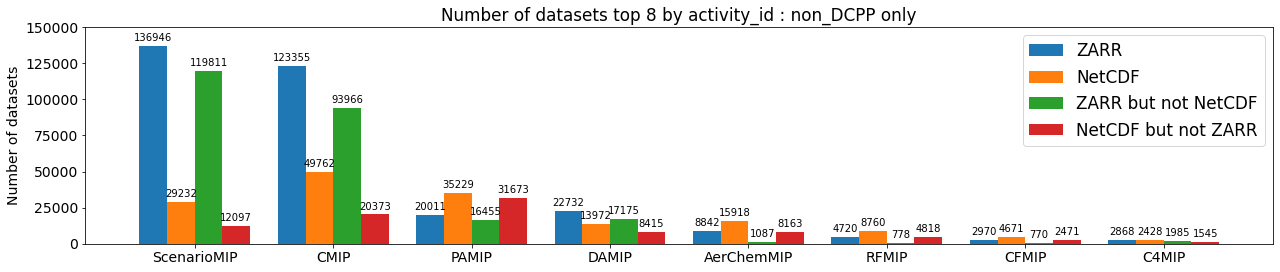

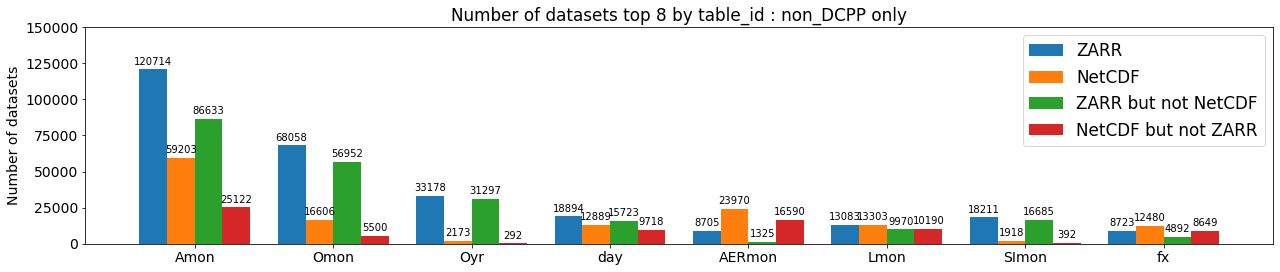

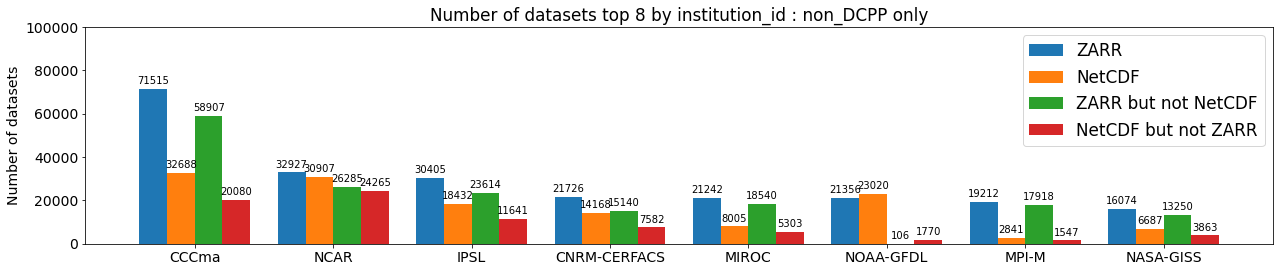

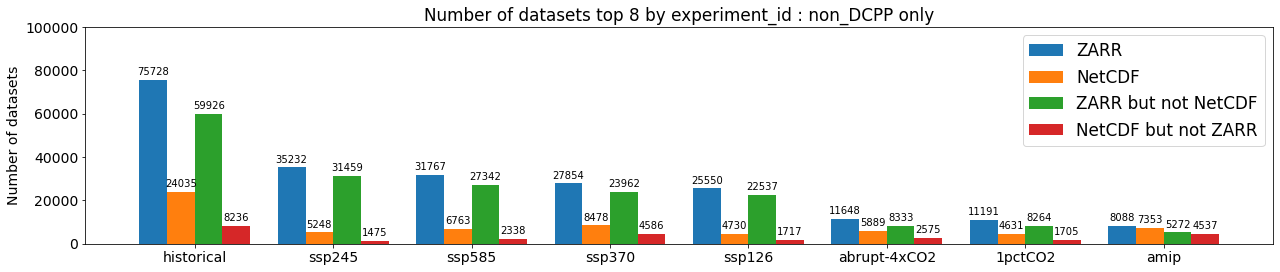

In [68]:
df_dict = {'ZARR':dZR,'NetCDF':dNC,'ZARR but not NetCDF':dZRnNC,'NetCDF but not ZARR':dNCnZR}
plot_facet(df_dict,facet='activity_id',ymax=150000,ylabel='Number of datasets',title_add = ' : non_DCPP only')
plot_facet(df_dict,facet='table_id',ymax=150000,ylabel='Number of datasets',title_add = ' : non_DCPP only')
plot_facet(df_dict,facet='institution_id',top_n=8,ymax=100000,ylabel='Number of datasets',title_add = ' : non_DCPP only')
plot_facet(df_dict,facet='experiment_id',ymax=100000,ylabel='Number of datasets',title_add = ' : non_DCPP only')


In [145]:
#TODO add t,g units for terabytes gigabytes if needed, with a default g
def plot_facet_size(df_dict,facet='table_id',top_n=8,ymax=300000,ylabel='number',title_add=''):   
    labels = df_dict.keys()
    stables = set()
    for label in labels:
        stables = stables.union(set(df_dict[label][facet].unique()))    
    tables = sorted(list(stables))
    vdfs = {}
    for label in labels:
        df = df_dict[label]
        nvdf = []
        for table in tables:
            ndf = df[df[facet]==table]['size'].sum()
            ndf = round(bytesto(ndf,'g'))
            nvdf += [ndf]
        vdfs[label] = nvdf
    names = []
    totals = []
    for item,table in enumerate(tables):
        names += [table]
        tsum = 0
        for label in labels:
            tsum += vdfs[label][item]
        totals += [tsum]
    num_dict = {'name': names,'total':totals}
    for label in labels:
        num_dict[label] = vdfs[label]
    
    df_nums = pd.DataFrame(num_dict)  
    
    df_nums = df_nums.sort_values(by=['total'],ascending=False)
    #df_nums = df_nums.sort_values(by=[list(labels)[1]],ascending=False)

    width = 1.0/(1+len(labels))  # the width of the bars
    
    fig, ax = plt.subplots()

    names = df_nums.name.values[:top_n]
    x = np.arange(len(names)) 
    
    for item,label in enumerate(labels):
        vdf = df_nums[label].values[:top_n]
        rects = ax.bar(x - (len(labels)/2-item-0.5)*width, vdf, width, label=label)
        autolabel(ax,rects)
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(ylabel)
    ax.set_title(f'{ylabel}, top {top_n} by {facet}'+title_add)
    ax.set_xticks(x)
    ax.set_xticklabels(names)
    ax.set_ylim([0,ymax])
    ax.legend()

    fig.tight_layout()
    #plt.savefig(f'compare-{facet}.png')

    plt.show()

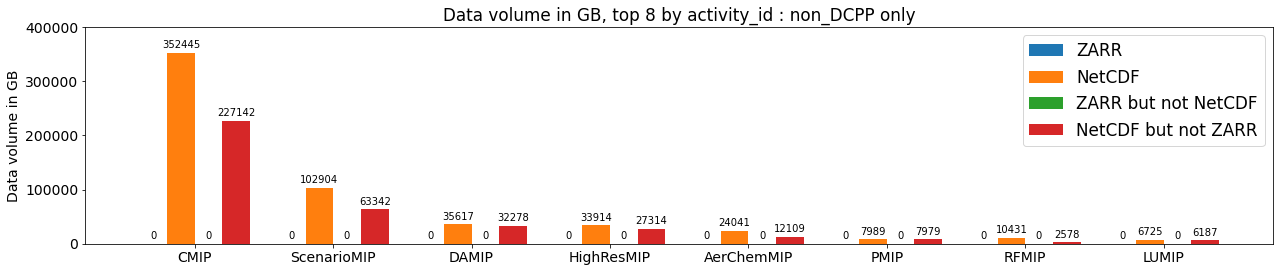

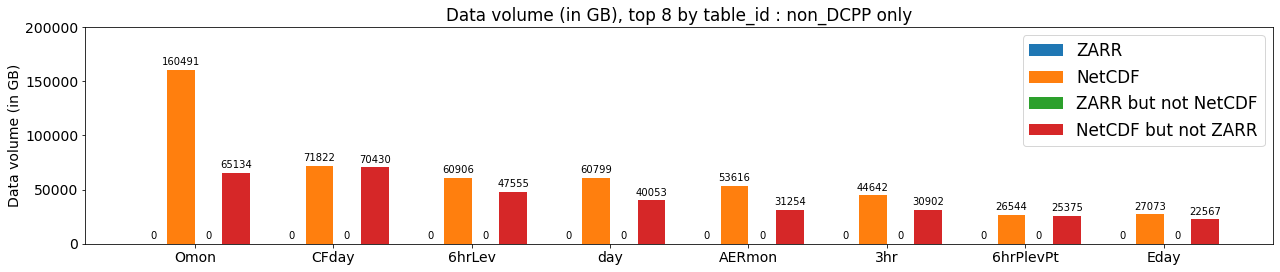

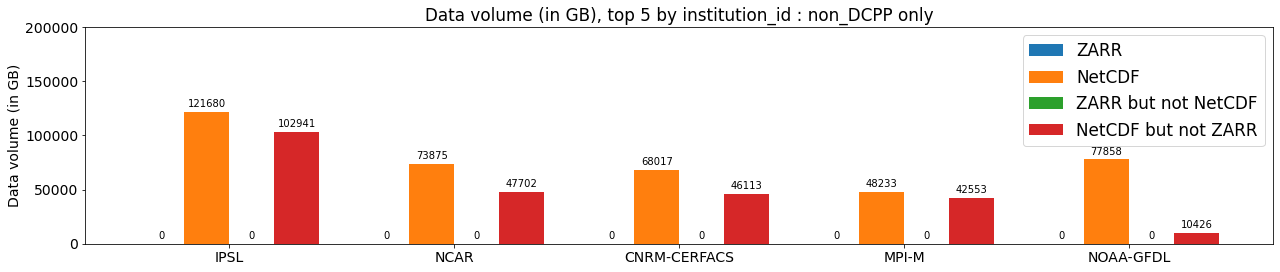

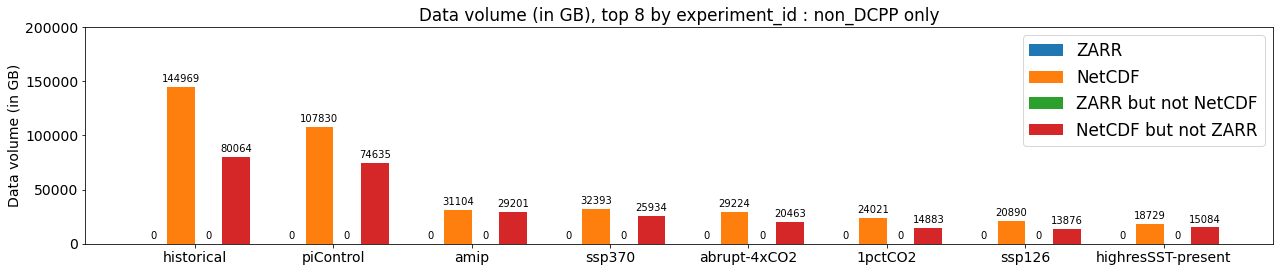

In [149]:
df_dict_size = {'ZARR':dZR,'NetCDF':dNC,'ZARR but not NetCDF':dZRnNC,'NetCDF but not ZARR':dNCnZR}

plot_facet_size(df_dict_size,facet='activity_id',ymax=400000, ylabel='Data volume in GB',title_add = ' : non_DCPP only')
plot_facet_size(df_dict_size,facet='table_id',ymax=200000,ylabel="Data volume (in GB)",title_add = ' : non_DCPP only')
plot_facet_size(df_dict_size,facet='institution_id',top_n=5,ymax=200000,ylabel="Data volume (in GB)",title_add = ' : non_DCPP only')
plot_facet_size(df_dict_size,facet='experiment_id',ymax=200000,ylabel="Data volume (in GB)",title_add = ' : non_DCPP only')


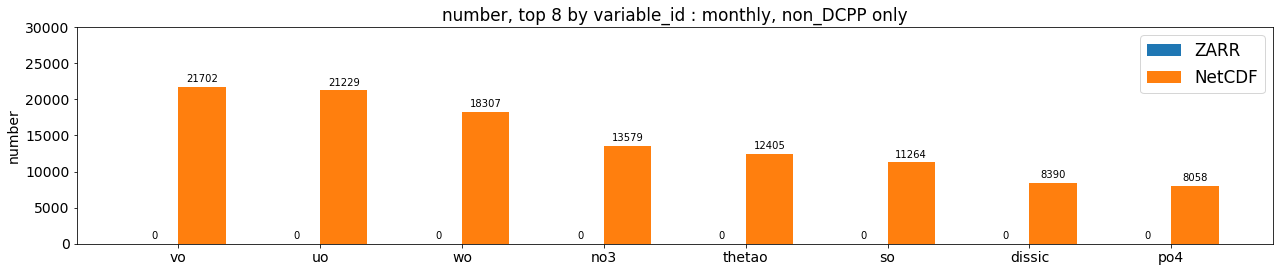

In [153]:
dZRm = dZR[dZR.table_id.str.contains('mon')]
dNCm = dNC[dNC.table_id.str.contains('mon')]
df_dict = {'ZARR':dZRm,'NetCDF':dNCm}
plot_facet_size(df_dict,facet='variable_id',ymax=30000,title_add = ' : monthly, non_DCPP only')